# Multiclass Binary Semantic Segmentation on KiTS19 Dataset

This notebook presents a deep learning framework for multiclass binary semantic segmentation using the KiTS19 (Kidney Tumor Segmentation Challenge 2019) dataset. The objective is to segment medical CT images into three regions—kidney, tumor, and background—by training a model to generate binary masks for each class. Accurate differentiation between these regions can support clinical decision-making and enhance diagnostic insights.

## Notebook Outline

1. **Importing Libraries and Modules**:
   - Load all required libraries for data preprocessing, model architecture, training, and evaluation.
   - Import custom data loading functions, transformation scripts, and model architecture from a local source directory for efficient modularity.

2. **Data Loading and Preprocessing**:
   - Load the KiTS19 dataset, including CT scans and manual segmentation annotations.
   - Apply a cropping transformation to both images and masks to ensure focus on regions of interest and reduce computational load.
   - Implement additional preprocessing techniques for improved image quality, including:
      - **Histogram Equalization**: Enhance contrast for better feature representation.
      - **Gaussian Blurring (k=5)**: Reduce noise and refine edges.
      - **Background Suppression**: Increase focus on kidney and tumor regions by minimizing background intensity.

3. **Data Visualization**:
   - Visualize samples of the transformed data and corresponding segmentation masks.
   - Confirm that the data and masks align correctly, with distinct channel representation for each class (background, kidney, tumor) for optimal model training.

4. **Model Initialization**:
   - Define and initialize the model architecture (e.g., U-Net), chosen for its effectiveness in medical segmentation tasks.
   - Configure the model for multiclass segmentation, specifying the loss function and optimizer to handle imbalanced data and support convergence.

5. **Defining Training and Validation Functions**:
   - Create functions to manage the training and validation loops, incorporating:
      - **Progress Monitoring**: Integrate `tqdm` to track training progress in real time.
      - **Loss Calculation and Comparison**: Track performance metrics, especially the loss for each class, to monitor model improvement.
      - **Checkpointing**: Save the model checkpoint with the lowest validation loss to ensure the best model is preserved.

6. **Model Training**:
   - Train the model over multiple epochs using the defined functions and transformations.
   - Track model progress using training and validation metrics to optimize segmentation accuracy on kidney and tumor regions. In this implementation, significant performance improvements were observed around epoch 18.

By the end of this notebook, you will have a trained multiclass segmentation model capable of accurately segmenting kidney and tumor regions within CT images from the KiTS19 dataset.

### Importing Libraries 

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
from source.dataloading import CroppedKiTSDataset
from source.models import U_Net
from source.transforms import HistogramEqualization, GaussianBlur, SuppressBackground
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Loading and Transforming KiTS19 Data

In [22]:
transform = transforms.Compose([
    GaussianBlur(kernel_size=5),
    HistogramEqualization(),
    transforms.ToTensor(),  
    SuppressBackground()
])

# Create datasets
train_path = r'C:\Users\pujau\OneDrive\Documents\thesis\kits19\data\train_data'
train_dataset = CroppedKiTSDataset(train_path, transform=transform, crop_size=(384,384))

val_path = r'C:\Users\pujau\OneDrive\Documents\thesis\kits19\data\val_data'
val_dataset = CroppedKiTSDataset(val_path, transform=transform, crop_size=(384,384))  

# Check the length of the datasets
print(f'Size of Train Dataset: {len(train_dataset)}')
print(f'Size of Val Dataset: {len(val_dataset)}')

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=6, shuffle=False, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=6, shuffle=False, pin_memory=True)

dataloaders = {
    'train': train_loader,
    'val': val_loader
}

dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

# Check dataloader sizes
print(f"Train loader batches: {len(train_loader)}")
print(f"Val loader batches: {len(val_loader)}")

# Check a single batch
for batch in train_loader:
    image, mask = batch
    print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")
    break


Size of Train Dataset: 37250
Size of Val Dataset: 2933
Train loader batches: 6209
Val loader batches: 489
Image shape: torch.Size([6, 1, 384, 384]), Mask shape: torch.Size([6, 3, 384, 384])


### Data Visualization

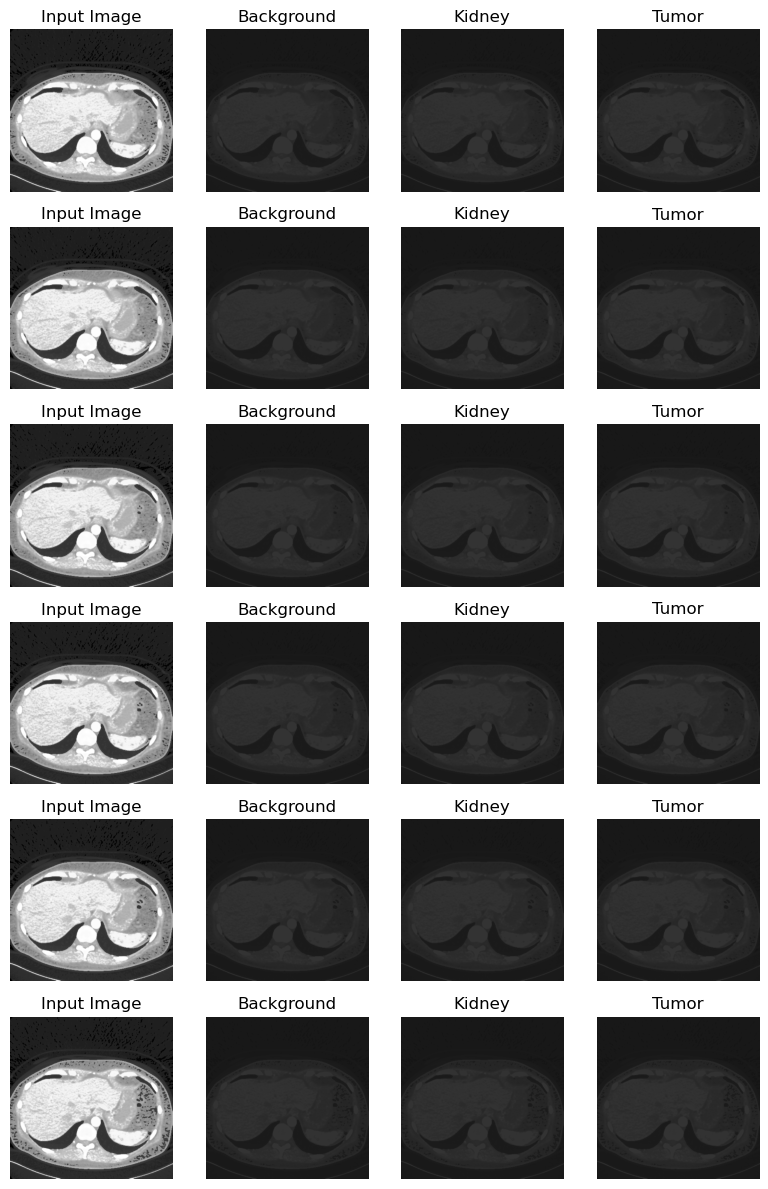

In [23]:
class_names = ["Background", "Kidney", "Tumor"]

n = 1 # number of batch want to visualize if 5 it will visualize first 5 batch from train_loader sequentially
for i, (images, labels) in enumerate(dataloaders['train']):
    if i == n:
        images = images
        labels = labels
        break

    batch_size = images.shape[0]
    num_channels = labels.shape[1]
    
    # Number of columns: 1 for image + number of channels for labels
    num_cols = num_channels + 1
    # Number of rows: based on batch size
    num_rows = batch_size

    # Create a grid for plotting
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 2 * num_rows))
    axes = np.atleast_2d(axes)  

    for b in range(batch_size):
        # Get the image and label for this batch
        image = images[b].squeeze().cpu().numpy()
        label = labels[b].cpu().numpy()

        # Visualize the input image
        ax = axes[b, 0]
        ax.imshow(image, cmap='gray')
        ax.set_title("Input Image")
        ax.axis('off')

        # Visualize each channel separately for the labels
        for c in range(num_channels):
            ax = axes[b, c + 1]
            # Overlay mask on image
            mask = label[c, :, :]
            ax.imshow(image, cmap='gray', alpha=0.6)
            ax.imshow(mask, cmap='gray', alpha=0.8)  
            ax.set_title(f"{class_names[c] if c < len(class_names) else f'Class {c}'}")
            ax.axis('off')

    plt.tight_layout()
    plt.show()

### Model Initialization

In [24]:

writer = SummaryWriter(log_dir='runs')
model = U_Net(img_ch=1, output_ch=3)
criterion = nn.CrossEntropyLoss()
num_epochs = 30
optimizer = optim.Adam(model.parameters(), lr=5e-6)

### Defining Training and Validation Functions

In [25]:
# Validation function
def validate_model(model, val_loader, device):
    model.eval()  
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            targets = targets

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    return val_loss / len(val_loader)

# Training loop with TensorBoard logging
def train_model(model, train_loader, val_loader, device, num_epochs=num_epochs):
    model.to(device)
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for inputs, targets in progress_bar:
            inputs, targets = inputs.to(device), targets.to(device)
            targets = targets 

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update running loss and progress bar
            running_loss += loss.item()
            progress_bar.set_postfix({'train_loss': running_loss / len(train_loader)})

        # Compute the average training loss
        avg_train_loss = running_loss / len(train_loader)

        # Validate the model after each epoch
        val_loss = validate_model(model, val_loader, device)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Log losses to TensorBoard
        writer.add_scalar('Loss/train', avg_train_loss, epoch+1)
        writer.add_scalar('Loss/val', val_loss, epoch+1)

        if val_loss < best_val_loss:
            best_val_loss = val_loss  
            torch.save(model.state_dict(), f'unet_weight_epoch_{epoch+1}_val_loss_{val_loss:.4f}.pth')  
            print(f"Model saved at epoch {epoch+1} with val_loss: {val_loss:.4f}")


    writer.close() 

### Training the Model

In [ ]:
torch.cuda.empty_cache()
train_model(model, train_loader, val_loader, device=device, num_epochs=num_epochs)